# Reconstructing the linear power (in velocity units)

This notebook looks at how accurately we can reconstruct the linear power spectrum, in velocity units.

In particular, we discuss models where we have changed the Hubble expansion (changes in $H_0$ and $\Omega_m$).

It follows the equations in Appendix C of the notes

In [1]:
%matplotlib inline
import camb_cosmo
import camb
import recons_cosmo
import linear_power_model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140

In [2]:
cosmo_fid = camb_cosmo.get_cosmology() ## Fiducial cosmology
cosmo_h=camb_cosmo.get_cosmology(H0=74.) ## Cosmology where we change H0

## Fit a LinearPowerModel to each cosmology
linP_fid=linear_power_model.LinearPowerModel(cosmo=cosmo_fid)
linP_h=linear_power_model.LinearPowerModel(cosmo=cosmo_h)

zs=[2.0,3.0,5.0] ## zs we're going to test for the power spectrum reconstructions

In [3]:
# Specify pivot point (in Mpc) where we want to make emulator calls
emu_kp_Mpc=0.7
# Specify pivot point (in km/s) where we define likelihood parameters
like_kp_kms=0.009
like_z_star=3.0
# setup object to reconstruct cosmology from compressed parameters
recons=recons_cosmo.ReconstructedCosmology(zs=zs,emu_kp_Mpc=emu_kp_Mpc,
                                           like_z_star=like_z_star,like_kp_kms=like_kp_kms,
                                           cosmo_fid=cosmo_fid)

In [4]:
print('params',linP_fid.get_params().keys())
print('fid',linP_fid.get_params().values())
print('h',linP_h.get_params().values())

params dict_keys(['f_star', 'g_star', 'Delta2_star', 'n_star', 'alpha_star'])
fid dict_values([0.9813935108004337, 0.9677508579459803, 0.3603423347991169, -2.299511628221443, -0.2162904297637917])
h dict_values([0.9758143773211623, 0.9577005905767146, 0.36028068834306826, -2.300640533651198, -0.21629143900384265])


### Reconstructing $H(z)$
Here we test how accurate $H(z)$ reconstructions are. All I'm doing here is comparing the true $H(z)$ as output by `CAMB` with the reconstructed one, although I'm not sure if degeneracies will play a role here.


In [5]:
print("Fiducial parameters:", linP_fid.get_params())
print("Test cosmology parameters:", linP_h.get_params())

Fiducial parameters: {'f_star': 0.9813935108004337, 'g_star': 0.9677508579459803, 'Delta2_star': 0.3603423347991169, 'n_star': -2.299511628221443, 'alpha_star': -0.2162904297637917}
Test cosmology parameters: {'f_star': 0.9758143773211623, 'g_star': 0.9577005905767146, 'Delta2_star': 0.36028068834306826, 'n_star': -2.300640533651198, 'alpha_star': -0.21629143900384265}


In [6]:
## Test how well H(z) is reconstructed
zs_h=np.linspace(2,5,100).tolist()
results_h = camb.get_results(cosmo_h.set_matter_power(redshifts=zs_h, kmax=2.0)) ## Run CAMB on cosmology with h=0.74
results_fid = camb.get_results(cosmo_fid.set_matter_power(redshifts=zs_h, kmax=2.0)) ## Run CAMB on fid cosmology

true_fid=np.empty(len(zs_h))
true_h=np.empty(len(zs_h))
recons_h=np.empty(len(zs_h))
for aa in range(len(zs_h)):
    true_fid[aa]=results_fid.hubble_parameter(zs_h[aa])
    true_h[aa]=results_h.hubble_parameter(zs_h[aa])
    recons_h[aa]=recons.reconstruct_Hubble(zs_h[aa],linP_h) ## Different h to fiducial cosmology

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


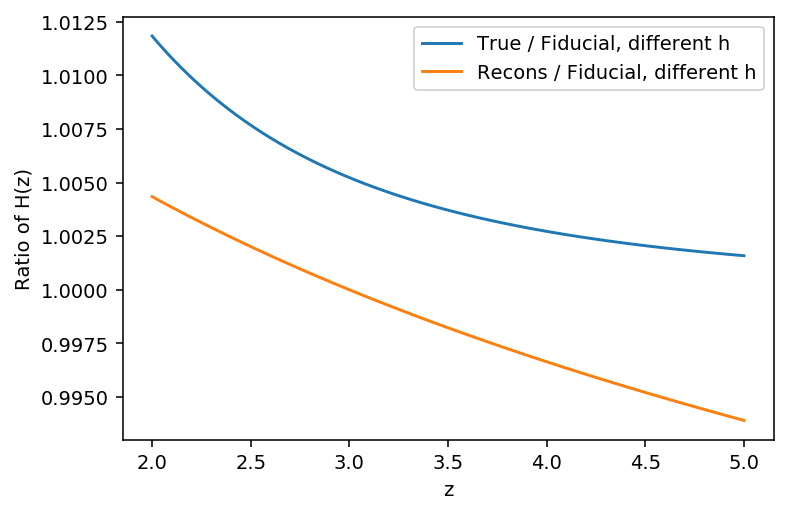

In [7]:
plt.plot(zs_h,true_h/true_fid,label="True / Fiducial, different h")
plt.plot(zs_h,recons_h/true_fid,label="Recons / Fiducial, different h")
plt.xlabel("z")
plt.ylabel("Ratio of H(z)")
plt.legend()

In [8]:
Hz3_fid=results_fid.hubble_parameter(z=3.0)
Hz3_h=results_h.hubble_parameter(z=3.0)
Hz3_recons=recons.reconstruct_Hubble(z=3.0,linP_model=linP_h)
print(Hz3_fid,Hz3_h,Hz3_recons)

306.68497996725597 308.28992350953706 306.68497996725597


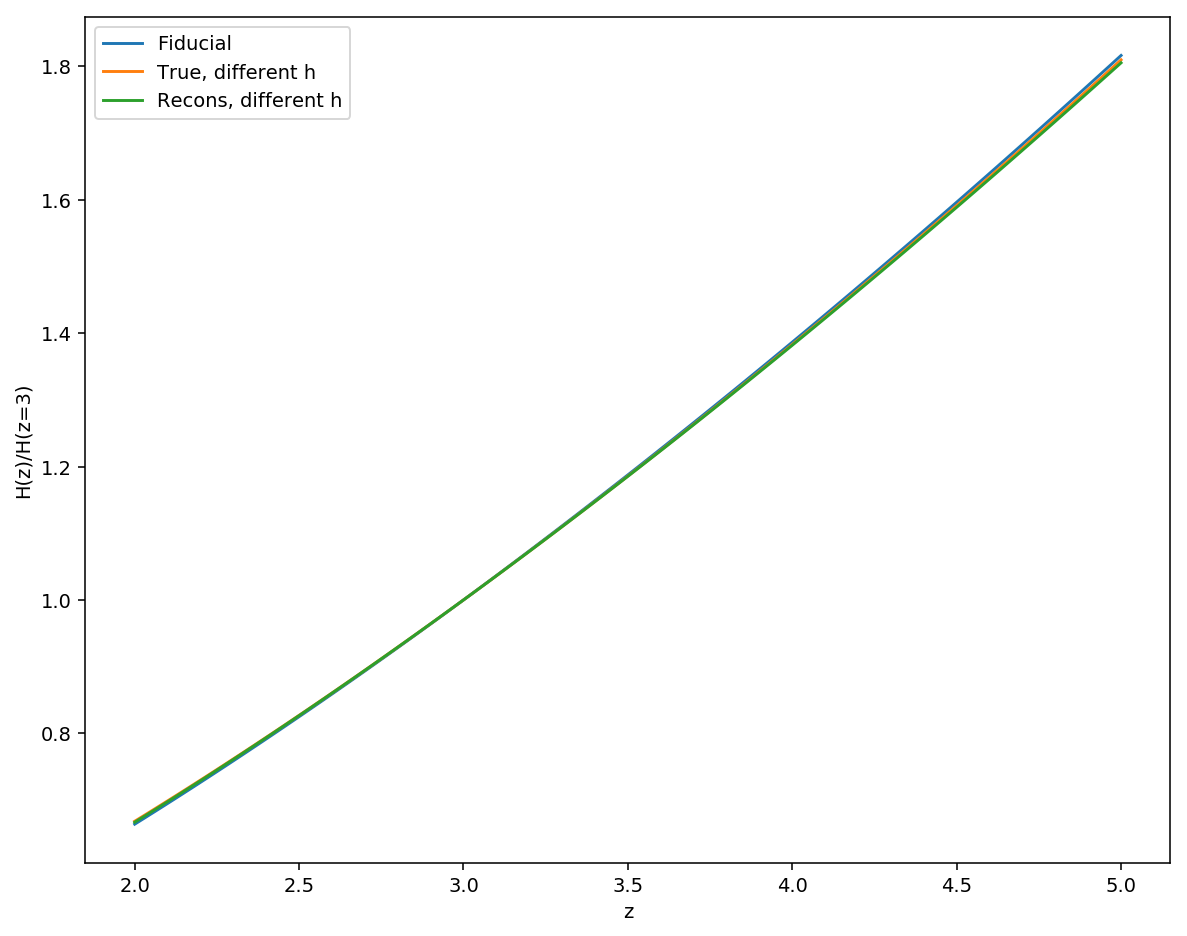

In [9]:
plt.figure(figsize=(10,8))
plt.plot(zs_h,true_fid/Hz3_fid,label="Fiducial")
plt.plot(zs_h,true_h/Hz3_h,label="True, different h")
plt.plot(zs_h,recons_h/Hz3_recons,label="Recons, different h")
plt.xlabel("z")
plt.ylabel("H(z)/H(z=3)")
plt.legend()

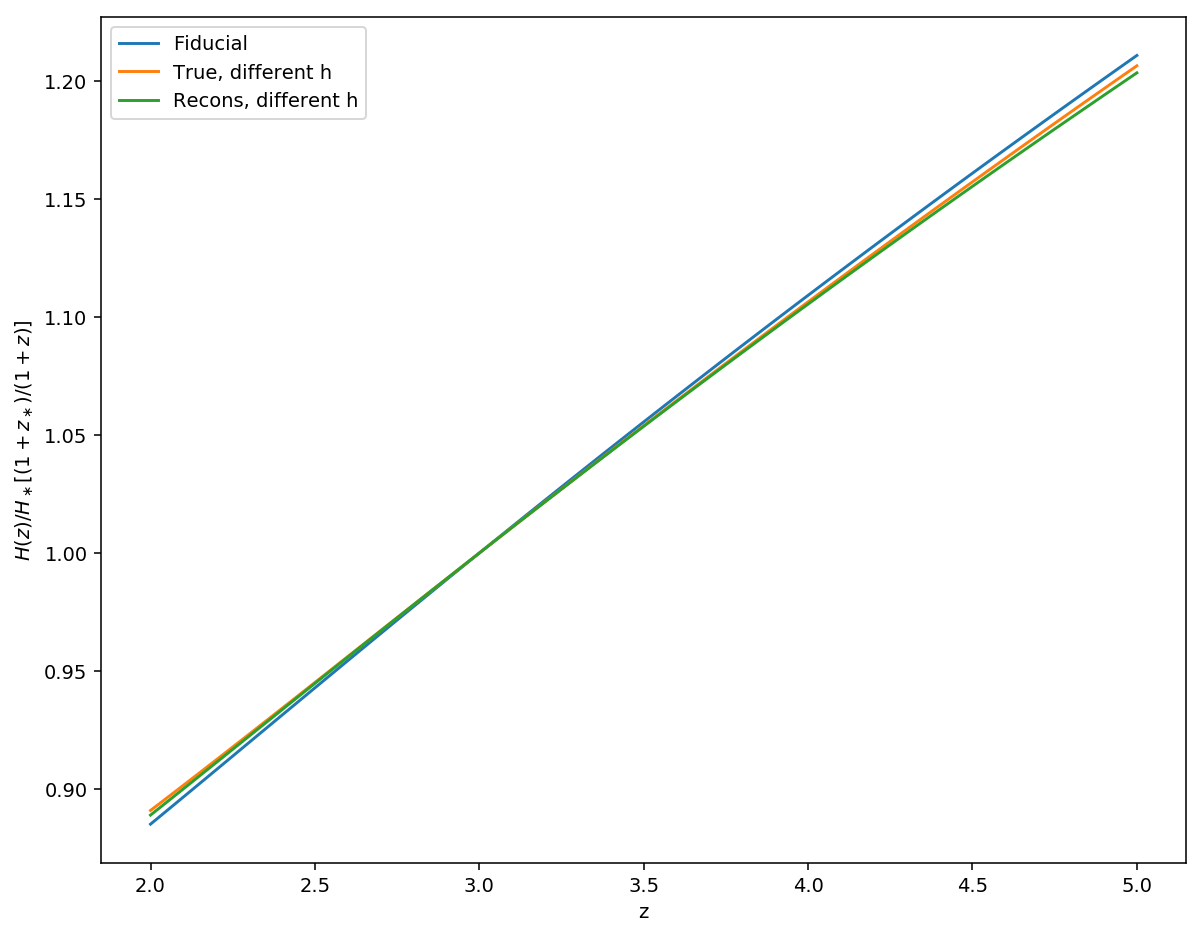

In [10]:
zzz=4.0/(1.0+np.array(zs_h))
plt.figure(figsize=(10,8))
plt.plot(zs_h,true_fid/Hz3_fid*zzz,label="Fiducial")
plt.plot(zs_h,true_h/Hz3_h*zzz,label="True, different h")
plt.plot(zs_h,recons_h/Hz3_recons*zzz,label="Recons, different h")
plt.xlabel("z")
plt.ylabel(r"$H(z)/H_\ast [(1+z_\ast)/(1+z)]$")
plt.legend()

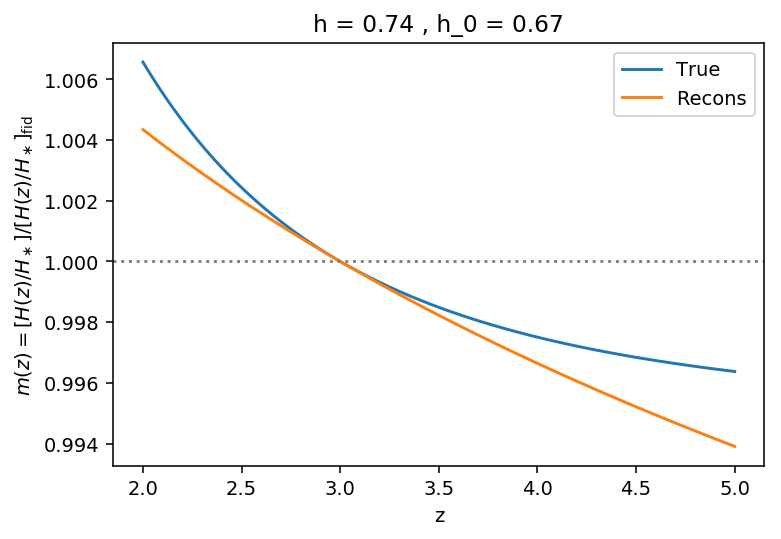

In [11]:
plt.plot(zs_h,(true_h/Hz3_h)/(true_fid/Hz3_fid),label='True')
plt.plot(zs_h,(recons_h/Hz3_recons)/(true_fid/Hz3_fid),label='Recons')
plt.legend()
plt.axhline(1.0,ls=':',color='gray')
plt.xlabel("z")
plt.ylabel(r"$m(z) = [H(z)/H_\ast] / [H(z)/H_\ast]_{\rm fid}$")
plt.title('h = {} , h_0 = {}'.format(cosmo_h.h,cosmo_fid.h))
plt.savefig('mz_h074.pdf')

### Reconstructing growth

In [12]:
# use few redshifts, computing D(z) is slow...
zs_h=np.linspace(2,5,10).tolist()
D_Dstar_fid=np.empty(len(zs_h))
D_Dstar_h=np.empty(len(zs_h))
recon_dz=np.empty(len(zs_h))
for aa in range(len(zs_h)):
    D_Dstar_fid[aa]=recons_cosmo.compute_D_Dstar(cosmo_fid,zs_h[aa],z_star=3.0)
    D_Dstar_h[aa]=recons_cosmo.compute_D_Dstar(cosmo_h,zs_h[aa],z_star=3.0)
    recon_dz[aa]=recons.reconstruct_dz(zs_h[aa],linP_model=linP_h)

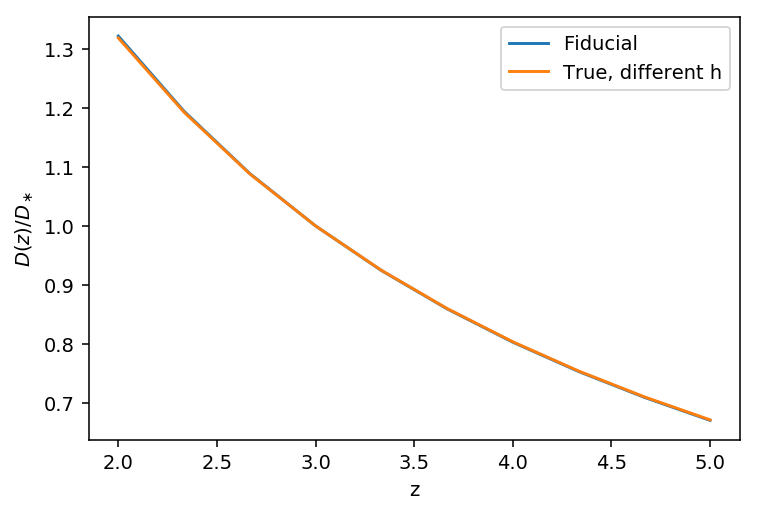

In [13]:
plt.plot(zs_h,D_Dstar_fid,label="Fiducial")
plt.plot(zs_h,D_Dstar_h,label="True, different h")
plt.xlabel("z")
plt.ylabel(r"$D(z)/D_\ast$")
plt.legend()

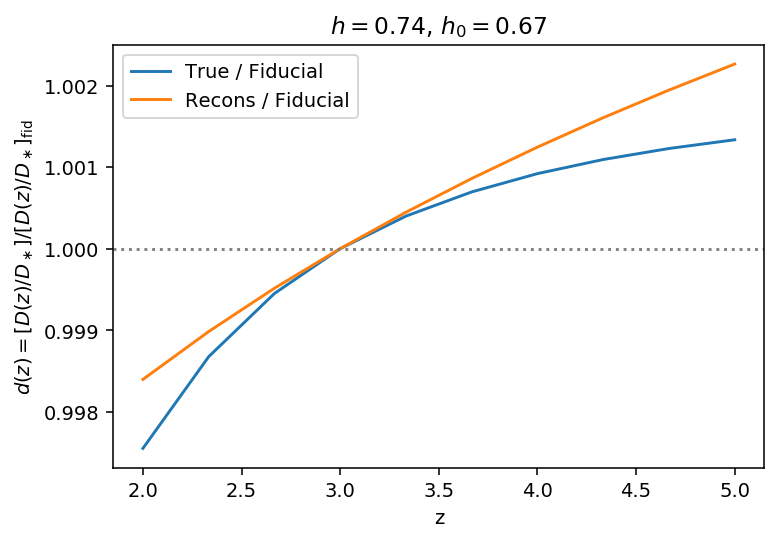

In [14]:
plt.plot(zs_h,D_Dstar_h/D_Dstar_fid,label="True / Fiducial")
plt.plot(zs_h,recon_dz,label="Recons / Fiducial")
plt.legend()
plt.axhline(1.0,ls=':',color='gray')
plt.xlabel("z")
plt.ylabel(r"$d(z)=[D(z)/D_\ast] / [D(z)/D_\ast]_{\rm fid}$")
plt.title(r"$h = {} $, $h_0 = {}$".format(cosmo_h.h,cosmo_fid.h))
plt.savefig('dz_h074.pdf')

### Compare linear power in velocity units

In [15]:
z=3
k_kms_fid,_,P_kms_fid=camb_cosmo.get_linP_kms(cosmo_fid,zs=[z])
k_kms_h,_,P_kms_h=camb_cosmo.get_linP_kms(cosmo_h,zs=[z])

Text(0, 0.5, 'Q(q)')

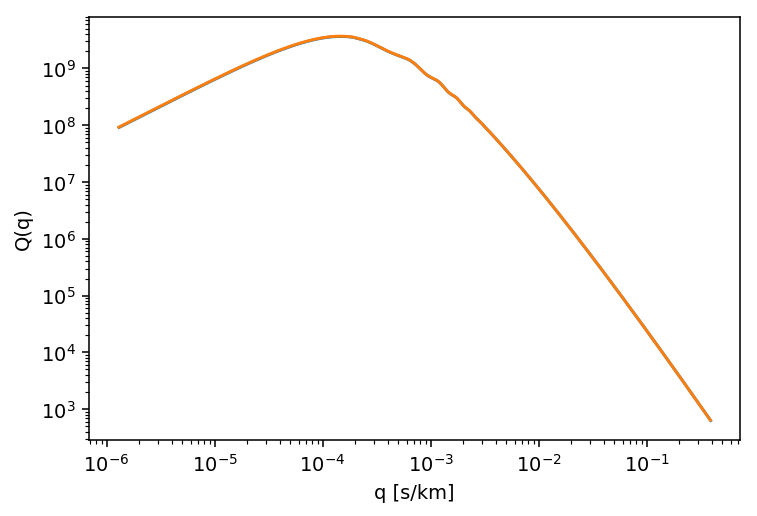

In [16]:
plt.loglog(k_kms_fid[0],P_kms_fid[0])
plt.loglog(k_kms_h[0],P_kms_h[0])
plt.xlabel('q [s/km]')
plt.ylabel('Q(q)')

The power spectra look very similar, and in EdS they would be identical. Let's look at the ratio.

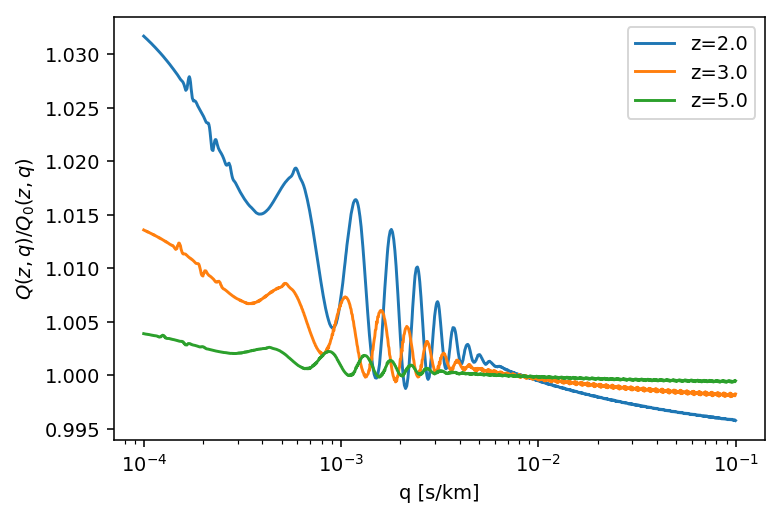

In [17]:
k_kms=np.logspace(-4,-1,1000)
for z in zs:
    k_kms_fid,_,P_kms_fid=camb_cosmo.get_linP_kms(cosmo_fid,zs=[z])
    k_kms_h,_,P_kms_h=camb_cosmo.get_linP_kms(cosmo_h,zs=[z])
    intP_kms_fid=np.interp(k_kms, k_kms_fid[0], P_kms_fid[0]) 
    intP_kms_h=np.interp(k_kms, k_kms_h[0], P_kms_h[0]) 
    plt.semilogx(k_kms,intP_kms_h/intP_kms_fid,label='z={}'.format(z))
plt.xlabel('q [s/km]')
plt.ylabel(r'$Q(z,q)/Q_0(z,q)$')
plt.legend()

### Reconstruct linear power

We will compare three models:
 - True linear power (True)
 - Reconstructed power using true values for m(z) and d(z) (Cheat)
 - Reconstructed power using (f_star, g_star) to approximate m(z) and d(z) (Approx)
 - Reconstructed power using m(z) = d(z) = 1.0 (Ignore)

In [18]:
# we can only reconstruct linear power up to camb_fit_kmax_Mpc (see camb_cosmo.py)
k_kms_max=recons.k_kms_fid[-1][-1]
k_kms=np.logspace(-3,np.log10(k_kms_max),1000)

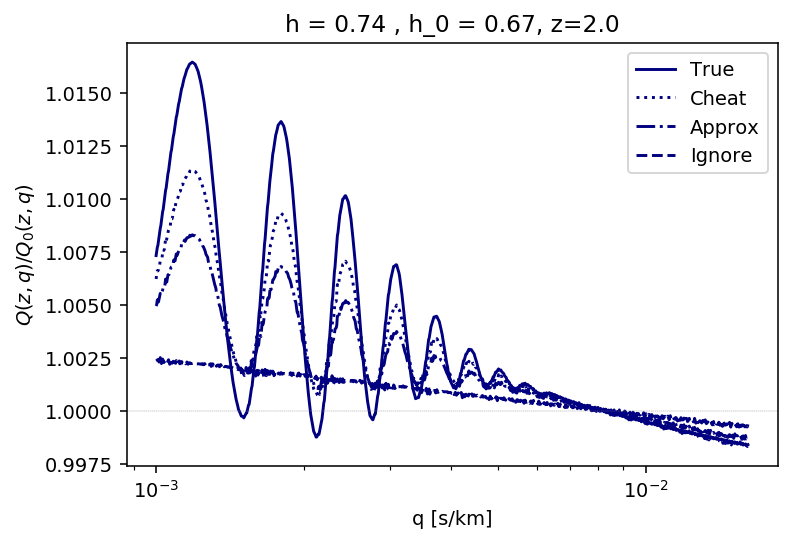

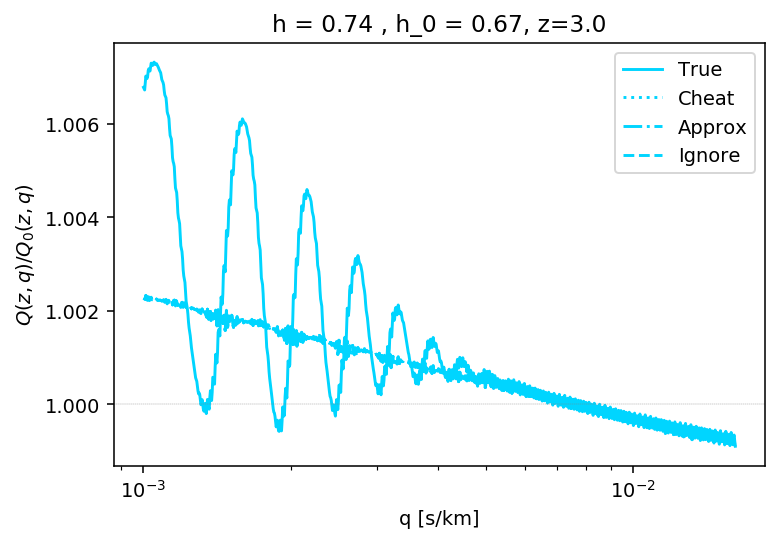

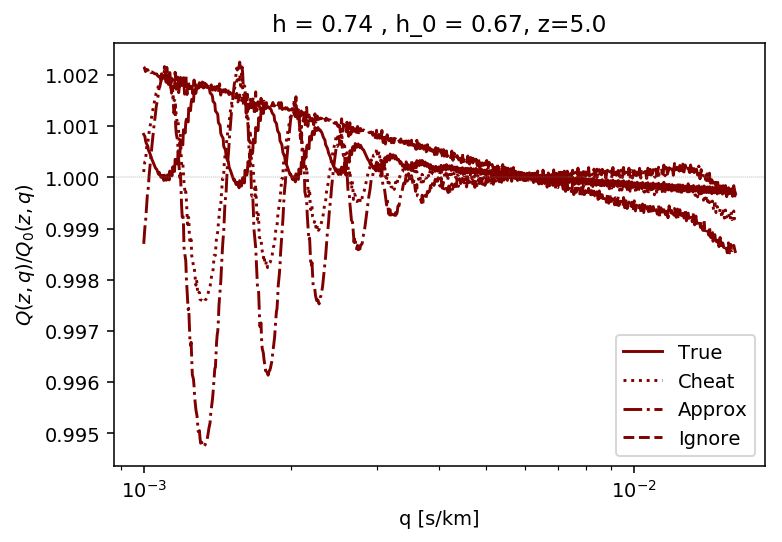

In [19]:
for iz in range(len(zs)):
    plt.figure()
    z=zs[iz]
    col = plt.cm.jet((z-zs[0])/(zs[-1]-zs[0]))
    cheat_P_kms=recons.reconstruct_linP_kms(iz,k_kms,linP_h,true_cosmo=cosmo_h)
    approx_P_kms=recons.reconstruct_linP_kms(iz,k_kms,linP_h)
    ignore_P_kms=recons.reconstruct_linP_kms(iz,k_kms,linP_h,ignore_f_star=True,ignore_g_star=True)
    
    k_kms_fid,_,P_kms_fid=camb_cosmo.get_linP_kms(cosmo_fid,zs=[z])
    k_kms_h,_,P_kms_h=camb_cosmo.get_linP_kms(cosmo_h,zs=[z])
    intP_kms_fid=np.interp(k_kms, k_kms_fid[0], P_kms_fid[0]) 
    intP_kms_h=np.interp(k_kms, k_kms_h[0], P_kms_h[0]) 
    plt.semilogx(k_kms,intP_kms_h/intP_kms_fid,'-',color=col,label='True')
    plt.semilogx(k_kms,cheat_P_kms/intP_kms_fid,':',color=col,label='Cheat')
    plt.semilogx(k_kms,approx_P_kms/intP_kms_fid,'-.',color=col,label='Approx')
    plt.semilogx(k_kms,ignore_P_kms/intP_kms_fid,'--',color=col,label='Ignore')

    plt.axhline(y=1.0,ls='--',lw=0.2,color='gray')
    plt.xlabel('q [s/km]')
    plt.ylabel(r'$Q(z,q)/Q_0(z,q)$')
    plt.legend()
    plt.title('h = {} , h_0 = {}, z={}'.format(cosmo_h.h,cosmo_fid.h,z))
    plt.savefig('recP_h074_{}.pdf'.format(iz))
    plt.show()